<a href="https://colab.research.google.com/github/ejihoon6065/Project_TurnAround/blob/master/Prophet_1years_To_1Month_DOING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [139]:
# 아래 코드를 돌리기전 아래 URL 참고할 것, Prophet모델에 input될 데이터의 상한 하한을 그날의 값의 ±10% 이상은 변동하지 않는 제한을 두는 내용

# 시계열 데이터는 일반적 데이터와는 다르게 순서가 존재하므로 일반적 cross validation 방법으로는  검증이 불가능함 -> one-step forecast validation 사용 
# one-step forecast validation: 시간이 지남에 따라 매일매일 업데이트되는 데이터로 모델을 업데이트하고 그다음 날을 예측하는 프로세스를 반복하는 방법

# https://predictor-ver1.tistory.com/6 

In [140]:
# https://colab.research.google.com/notebooks/snippets/importing_libraries.ipynb 참고

In [141]:
import pandas as pd
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#sns.set() # setting seaborn default for plots
import matplotlib.font_manager as fm
import copy
# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False
import numpy as np


from scipy import stats  # Box-Cox 검정
import statsmodels.api as sm  # qqplot
from statsmodels.tsa.stattools import adfuller    # adfuller : ADF그래프 그려주는 함수
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
from statsmodels.stats.diagnostic import acorr_ljungbox # Ljung-Box 검정

import warnings
warnings.filterwarnings("ignore")

import itertools
import copy
import datetime

In [142]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [143]:
pip install -U pykrx  # KRX데이터를 크롤링하기 위한 라이브러리설치

Requirement already up-to-date: pykrx in /usr/local/lib/python3.6/dist-packages (0.1.41)


In [144]:
from pykrx import stock
df = stock.get_market_ohlcv_by_date("20190701", "20200831", "122870") # DataFrame, (시작날짜,종료날짜,종목번호)
df

와이지엔터테인먼트,시가,고가,저가,종가,거래량
날짜,,,,,
2019-07-01,29100,29400,28400,28500,233660
2019-07-02,28250,29800,28200,29000,384554
2019-07-03,29300,29300,28350,28550,264976
2019-07-04,28550,29150,28500,28850,131863
2019-07-05,29000,29200,28600,29050,126249
...,...,...,...,...,...
2020-08-25,47200,49350,47000,48700,397671
2020-08-26,48750,50800,48100,50400,586564
2020-08-27,49950,51400,49450,50900,528784


In [145]:
# train,test 데이터 나누기

train = df[:'2020-07-01']                   # 2019-07-01 ~ 2020-07-01 (약 1년) 
test = df['2020-07-01':]                    # 2020-07-02 ~ 2020-08-31 (약 2달)
# 각 데이터의 column=['시가', '고가', '저가', '종가', '거래량']

# Prophet모델에 input되기 위해서는 ['ds','y']로 column형식을 맞춰야 함

train['날짜']=train.index
train=pd.DataFrame({'ds':train['날짜'],'y':train['종가']})
train=train.reset_index(drop=True)


test['날짜']=test.index
test=pd.DataFrame({'y':test['종가']})
#test=test.reset_index(drop=True)



In [146]:
print(train.shape) # 245 x 2
print(test.shape) # 43 x 1

(249, 2)
(43, 1)


In [148]:
from fbprophet import Prophet

# https://hyperconnect.github.io/2020/03/09/prophet-package.html 참고하여 parameter 조정

'''
Parameters
    ----------
    growth: String 'linear' or 'logistic' to specify a linear or logistic
        trend.
    changepoints: List of dates at which to include potential changepoints. If
        not specified, potential changepoints are selected automatically.
    n_changepoints: Number of potential changepoints to include. Not used
        if input `changepoints` is supplied. If `changepoints` is not supplied,
        then n_changepoints potential changepoints are selected uniformly from
        the first `changepoint_range` proportion of the history.
    changepoint_range: Proportion of history in which trend changepoints will
        be estimated. Defaults to 0.8 for the first 80%. Not used if
        `changepoints` is specified.
    yearly_seasonality: Fit yearly seasonality.
        Can be 'auto', True, False, or a number of Fourier terms to generate.
    weekly_seasonality: Fit weekly seasonality.
        Can be 'auto', True, False, or a number of Fourier terms to generate.
    daily_seasonality: Fit daily seasonality.
        Can be 'auto', True, False, or a number of Fourier terms to generate.
    holidays: pd.DataFrame with columns holiday (string) and ds (date type)
        and optionally columns lower_window and upper_window which specify a
        range of days around the date to be included as holidays.
        lower_window=-2 will include 2 days prior to the date as holidays. Also
        optionally can have a column prior_scale specifying the prior scale for
        that holiday.
    seasonality_mode: 'additive' (default) or 'multiplicative'.
    seasonality_prior_scale: Parameter modulating the strength of the
        seasonality model. Larger values allow the model to fit larger seasonal
        fluctuations, smaller values dampen the seasonality. Can be specified
        for individual seasonalities using add_seasonality.
    holidays_prior_scale: Parameter modulating the strength of the holiday
        components model, unless overridden in the holidays input.
    changepoint_prior_scale: Parameter modulating the flexibility of the
        automatic changepoint selection. Large values will allow many
        changepoints, small values will allow few changepoints.
    mcmc_samples: Integer, if greater than 0, will do full Bayesian inference
        with the specified number of MCMC samples. If 0, will do MAP
        estimation.
    interval_width: Float, width of the uncertainty intervals provided
        for the forecast. If mcmc_samples=0, this will be only the uncertainty
        in the trend using the MAP estimate of the extrapolated generative
        model. If mcmc.samples>0, this will be integrated over all model
        parameters, which will include uncertainty in seasonality.
    uncertainty_samples: Number of simulated draws used to estimate
        uncertainty intervals. Settings this value to 0 or False will disable
        uncertainty estimation and speed up the calculation.
    stan_backend: str as defined in StanBackendEnum default: None - will try to
        iterate over all available backends and find the working one
    """
'''

'\nParameters\n    ----------\n    growth: String \'linear\' or \'logistic\' to specify a linear or logistic\n        trend.\n    changepoints: List of dates at which to include potential changepoints. If\n        not specified, potential changepoints are selected automatically.\n    n_changepoints: Number of potential changepoints to include. Not used\n        if input `changepoints` is supplied. If `changepoints` is not supplied,\n        then n_changepoints potential changepoints are selected uniformly from\n        the first `changepoint_range` proportion of the history.\n    changepoint_range: Proportion of history in which trend changepoints will\n        be estimated. Defaults to 0.8 for the first 80%. Not used if\n        `changepoints` is specified.\n    yearly_seasonality: Fit yearly seasonality.\n        Can be \'auto\', True, False, or a number of Fourier terms to generate.\n    weekly_seasonality: Fit weekly seasonality.\n        Can be \'auto\', True, False, or a number o

In [149]:
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip # 진행상태바 표시를 위한 tqdm 라이브러리 설치 

  Using cached https://github.com/chengs/tqdm/archive/colab.zip
  Created wheel for tqdm: filename=tqdm-4.28.1-py2.py3-none-any.whl size=47868 sha256=14a02faba8fc9fad4abd144e6d848796d3bec69dee211106b0ba16733f9d3d6c
  Stored in directory: /tmp/pip-ephem-wheel-cache-9pbi5kvl/wheels/41/18/ee/d5dd158441b27965855b1bbae03fa2d8a91fe645c01b419896
Successfully built tqdm
ERROR: spacy 2.2.4 has requirement tqdm<5.0.0,>=4.38.0, but you'll have tqdm 4.28.1 which is incompatible.
ERROR: fbprophet 0.7.1 has requirement tqdm>=4.36.1, but you'll have tqdm 4.28.1 which is incompatible.
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


In [155]:
from tqdm import tqdm_notebook as tqdm
from time import sleep 
from datetime import datetime

In [153]:
cp=['2019-07-31','2019-08-28','2019-09-20','2019-09-27','2019-10-14','2019-10-30','2019-11-14','2019-11-21','2020-01-13','2020-01-21','2020-02-03','2020-02-17','2020-03-06','2020-03-23','2020-04-28','2020-06-15','2020-06-26']

In [157]:
print(len(cp))

17


In [154]:
train['cap'] = train['y'].shift() * 1.3
train['floor'] = train['y'].shift() * 0.7
train.fillna(method='bfill', inplace=True)
train

,ds,y,cap,floor
0,2019-07-01,28500,37050.0,19950.0
1,2019-07-02,29000,37050.0,19950.0
2,2019-07-03,28550,37700.0,20300.0
3,2019-07-04,28850,37115.0,19985.0
4,2019-07-05,29050,37505.0,20195.0
...,...,...,...,...
244,2020-06-25,32500,40950.0,22050.0
245,2020-06-26,33850,42250.0,22750.0
246,2020-06-29,37000,44005.0,23695.0
247,2020-06-30,37250,48100.0,25900.0


In [106]:
test.shape

(43, 1)

In [156]:
for i in tqdm(range(43),desc='tqdm'):

  prophet_model = Prophet(growth = 'logistic',
                          daily_seasonality = True,
                          yearly_seasonality = False,
                          changepoints=cp,                       # 
                          changepoint_prior_scale=0.2,           # changepoint_prior_scale : 0.05
                          changepoint_range=0.85,                 # default : 0.8
                          )

  prophet_model.fit(train)
  future =  prophet_model.make_future_dataframe(periods=1)
  future['cap'] = train['cap'].append(pd.Series(train['y'].values[-1]*1.3),ignore_index=True)
  future['floor'] = train['floor'].append(pd.Series(train['y'].values[-1]*0.7),ignore_index=True)
  future.fillna(method='bfill', inplace=True)

  prophet_forecast = prophet_model.predict(future)

  cap=list(prophet_forecast['yhat'])[-2]*1.3
  flor=list(prophet_forecast['yhat'])[-2]*0.7
  ds=prophet_forecast['ds'][-1:]
  y=prophet_forecast['yhat'][-1:]
  sub=pd.DataFrame({'ds':ds,'y':y,'cap':cap,'floor':flor})

  train=pd.concat([train,sub])

In [164]:
test # 2019-07-01 ~ 2020-08-31

,y
날짜,
2020-07-01,35600
2020-07-02,39450
2020-07-03,38750
2020-07-06,39200
2020-07-07,38600
2020-07-08,40400
2020-07-09,39600
2020-07-10,38350
2020-07-13,38250


In [165]:
prophet_pred=prophet_forecast.tail(43) # 2019-07-01 ~ 2020-08-13
print(test.shape)          # 2020-07-01 ~ 2020-08-12  [43 x 1]
prophet_pred  # 2020-07-02 ~ 2020-08-13  [43 x 18] 

(43, 1)


,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
249,2020-07-02,37486.076608,48705.380275,26225.973994,36277.285205,38573.358089,37486.076608,37486.076608,-67.628658,-67.628658,-67.628658,-283.651645,-283.651645,-283.651645,216.022986,216.022986,216.022986,0.0,0.0,0.0,37418.447949
250,2020-07-03,37451.152264,48659.935823,26201.503905,36099.452435,38349.568229,37451.152264,37451.152264,-278.865380,-278.865380,-278.865380,-283.651645,-283.651645,-283.651645,4.786264,4.786264,4.786264,0.0,0.0,0.0,37172.286884
251,2020-07-04,37153.670103,48273.353027,25993.343937,34296.842546,36548.343056,37153.670103,37153.670103,-1737.232286,-1737.232286,-1737.232286,-283.651645,-283.651645,-283.651645,-1453.580642,-1453.580642,-1453.580642,0.0,0.0,0.0,35416.437817
252,2020-07-05,35431.145230,46035.231621,24788.201642,34032.411556,36199.150847,35431.145230,35431.145230,-265.841420,-265.841420,-265.841420,-283.651645,-283.651645,-283.651645,17.810225,17.810225,17.810225,0.0,0.0,0.0,35165.303810
253,2020-07-06,35173.720298,45700.699310,24608.068859,34208.708016,36428.851946,35173.720298,35173.720298,93.936294,93.936294,93.936294,-283.651645,-283.651645,-283.651645,377.587938,377.587938,377.587938,0.0,0.0,0.0,35267.656591
254,2020-07-07,35295.030632,45858.252424,24692.905152,34374.174160,36656.349761,35295.030632,35295.030632,141.908007,141.908007,141.908007,-283.651645,-283.651645,-283.651645,425.559651,425.559651,425.559651,0.0,0.0,0.0,35436.938638
255,2020-07-08,35457.372879,46069.117117,24806.447679,34492.209817,36670.619920,35457.372879,35457.372879,128.161932,128.161932,128.161932,-283.651645,-283.651645,-283.651645,411.813577,411.813577,411.813577,0.0,0.0,0.0,35585.534811
256,2020-07-09,35611.013216,46268.675008,24913.901927,34381.416172,36691.618518,35611.013216,35611.013216,-67.628658,-67.628658,-67.628658,-283.651645,-283.651645,-283.651645,216.022986,216.022986,216.022986,0.0,0.0,0.0,35543.384558
257,2020-07-10,35545.508025,46183.501352,24868.039190,34149.976181,36545.135495,35545.508025,35545.508025,-278.865380,-278.865380,-278.865380,-283.651645,-283.651645,-283.651645,4.786264,4.786264,4.786264,0.0,0.0,0.0,35266.642645
258,2020-07-11,35275.112112,45832.118267,24678.832913,32518.660663,34731.816292,35275.112112,35275.112112,-1737.232286,-1737.232286,-1737.232286,-283.651645,-283.651645,-283.651645,-1453.580642,-1453.580642,-1453.580642,0.0,0.0,0.0,33537.879826


In [166]:
prophet_pred.index=prophet_pred['ds']
prophet_pred

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,,
2020-07-02,2020-07-02,37486.076608,48705.380275,26225.973994,36277.285205,38573.358089,37486.076608,37486.076608,-67.628658,-67.628658,-67.628658,-283.651645,-283.651645,-283.651645,216.022986,216.022986,216.022986,0.0,0.0,0.0,37418.447949
2020-07-03,2020-07-03,37451.152264,48659.935823,26201.503905,36099.452435,38349.568229,37451.152264,37451.152264,-278.865380,-278.865380,-278.865380,-283.651645,-283.651645,-283.651645,4.786264,4.786264,4.786264,0.0,0.0,0.0,37172.286884
2020-07-04,2020-07-04,37153.670103,48273.353027,25993.343937,34296.842546,36548.343056,37153.670103,37153.670103,-1737.232286,-1737.232286,-1737.232286,-283.651645,-283.651645,-283.651645,-1453.580642,-1453.580642,-1453.580642,0.0,0.0,0.0,35416.437817
2020-07-05,2020-07-05,35431.145230,46035.231621,24788.201642,34032.411556,36199.150847,35431.145230,35431.145230,-265.841420,-265.841420,-265.841420,-283.651645,-283.651645,-283.651645,17.810225,17.810225,17.810225,0.0,0.0,0.0,35165.303810
2020-07-06,2020-07-06,35173.720298,45700.699310,24608.068859,34208.708016,36428.851946,35173.720298,35173.720298,93.936294,93.936294,93.936294,-283.651645,-283.651645,-283.651645,377.587938,377.587938,377.587938,0.0,0.0,0.0,35267.656591
2020-07-07,2020-07-07,35295.030632,45858.252424,24692.905152,34374.174160,36656.349761,35295.030632,35295.030632,141.908007,141.908007,141.908007,-283.651645,-283.651645,-283.651645,425.559651,425.559651,425.559651,0.0,0.0,0.0,35436.938638
2020-07-08,2020-07-08,35457.372879,46069.117117,24806.447679,34492.209817,36670.619920,35457.372879,35457.372879,128.161932,128.161932,128.161932,-283.651645,-283.651645,-283.651645,411.813577,411.813577,411.813577,0.0,0.0,0.0,35585.534811
2020-07-09,2020-07-09,35611.013216,46268.675008,24913.901927,34381.416172,36691.618518,35611.013216,35611.013216,-67.628658,-67.628658,-67.628658,-283.651645,-283.651645,-283.651645,216.022986,216.022986,216.022986,0.0,0.0,0.0,35543.384558
2020-07-10,2020-07-10,35545.508025,46183.501352,24868.039190,34149.976181,36545.135495,35545.508025,35545.508025,-278.865380,-278.865380,-278.865380,-283.651645,-283.651645,-283.651645,4.786264,4.786264,4.786264,0.0,0.0,0.0,35266.642645


<function matplotlib.pyplot.show>

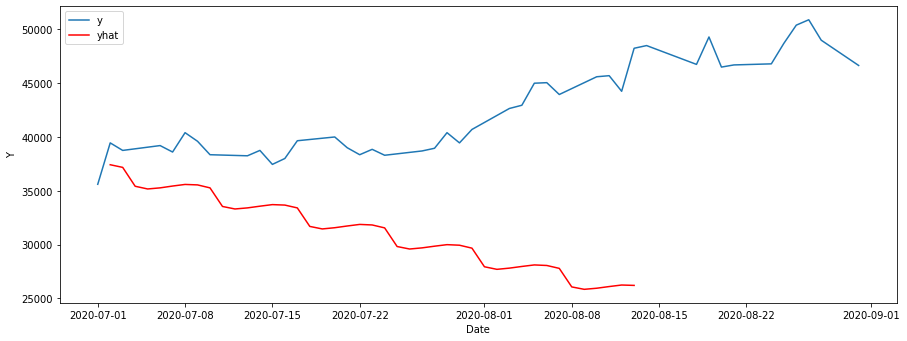

In [167]:
# y(test)와 yhat(prophet_pred)비교

fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(211)
ax1.plot(test['y'],label='y' )
ax1.plot(prophet_pred['yhat'],color='red',label='yhat')
ax1.set_xlabel('Date')
ax1.set_ylabel('Y')
ax1.legend(loc=2)
plt.show

In [168]:
mape = ((abs( prophet_pred['yhat'] - test['y'] ) / test['y'])*100).mean()
print('The MAPE of our forecasts is {}%'.format( round(mape, 2) ) ) 


The MAPE of our forecasts is 22.3%


In [ ]:
'''
#for i in range(0,43):

for i in train['ds']:
  i=i.strftime("%Y-%m-%d")
  if i in cp:
    print(i)
prophet_series = pd.DataFrame([train.index, train['y']]).T
prophet_series.columns = ['ds','y']
prophet_series['cap'] = prophet_series['y'].shift() * 1.2     # 데이터의 상한을 직전날 종가의 ±20% 이상은 변동하지 않도록 제한
prophet_series['floor'] = prophet_series['y'].shift() * 0.8   # 데이터의 하한을 직전날 종가의 ±20% 이상은 변동하지 않도록 제한  (logistic한 prophet예측을 위해서는 제한을 걸어야 함)
prophet_series.fillna(method='bfill', inplace=True)


prophet_model = Prophet(growth = 'logistic', 
                        daily_seasonality = True,
                        changepoint_prior_scale=0.2,
                        )

prophet_model.fit(prophet_series)

future =  prophet_model.make_future_dataframe(periods=1)
future['cap'] = prophet_series['cap'].append(pd.Series(prophet_series['y'].values[-1]*1.2),ignore_index=True)
future['floor'] = prophet_series['floor'].append(pd.Series(prophet_series['y'].values[-1]*0.8),ignore_index=True)
future.fillna(method='bfill', inplace=True)

prophet_forecast = prophet_model.predict(future)
print(prophet_forecast.tail(1))
print()
print(test1.head(1))



for i in tqdm(range(start, end),desc='tqdm'):
  data = train[i:i+training_period+n_steps]

n_steps = 20                                    # 한달마다 업데이트
training_period = 20 + n_steps                  # 학습은 train은 전 구간이 아닌 예측날 기준 80일(4개월) 이전의 데이터만 학습
end = len(train) - n_steps - training_period    
validation_size = 20                 
start = end - validation_size

print(start-end) 

#for i in range(start, end):
  #print(train[i:i+training_period+n_steps]) 
  #print()
'''

  
'''